# Maize response to phosphorus fertilisation: Loading and aranging data

This project aims at identifying factors that influence how maize responses to phosphorus fertilization. Several aspects are covered. This notebook aims at preprocessing the data for further analyses.

## Loading packages

The computations are performed with the R statistical language, in a Jupyter environment. We will need the following packages, as well as an in-house function.

In [1]:
library("tidyverse") # ggplot2 and dplyr
library("compositions") # Compositional data analysis
library("vegan")# Principal components analysis
library("VIM") # Visualize missing data
library("mice")# Missing values imputation
library("randomForest") # Needed for the mice package
library("ggmap")
source('libs/ilrNA.R') # Put NA to ilr missing values

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: tensorA

Attaching package: ‘tensorA’

The following object is masked from ‘package:base’:

    norm

Loading required package: robustbase
Loading required package: energy
Loading required package: bayesm
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"


Attaching package: ‘compositions’

The following objects are masked from ‘package:stats’:

    cor, cov, dist, var

The following objects are masked from ‘package:base’:

    %*%, scale, scale.default

Loading required package: permute
Loading required package: lattice
This is ve

## Loading data

We are using several `csv` files, included in the `data` folder. The main table includes the fertilizer trials.

In [2]:
main_data <- read_csv("data/data.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  Crop = col_character(),
  `Plantation date` = col_character(),
  `Harvest date` = col_date(format = ""),
  Texture = col_character(),
  `Soil Series` = col_character(),
  Manure = col_character(),
  P.Source = col_character(),
  P.rate_kgP2o5.ha_4 = col_logical(),
  Yield_t.ha_4 = col_logical(),
  `Grain density g.L 4` = col_logical(),
  `Grain mositure % 4` = col_logical(),
  DDCm = col_logical(),
  DDCm_30 = col_logical()
)
See spec(...) for full column specifications.


### Map

We fetch the map from Stamen.

In [3]:
qc_map <- get_stamenmap(bbox = c(left = -76, right = -68, bottom = 44.6, top = 50), 
                         zoom = 7, maptype = 'toner-lite')

Source : http://tile.stamen.com/toner-lite/7/36/43.png
Source : http://tile.stamen.com/toner-lite/7/37/43.png
Source : http://tile.stamen.com/toner-lite/7/38/43.png
Source : http://tile.stamen.com/toner-lite/7/39/43.png
Source : http://tile.stamen.com/toner-lite/7/36/44.png
Source : http://tile.stamen.com/toner-lite/7/37/44.png
Source : http://tile.stamen.com/toner-lite/7/38/44.png
Source : http://tile.stamen.com/toner-lite/7/39/44.png
Source : http://tile.stamen.com/toner-lite/7/36/45.png
Source : http://tile.stamen.com/toner-lite/7/37/45.png
Source : http://tile.stamen.com/toner-lite/7/38/45.png
Source : http://tile.stamen.com/toner-lite/7/39/45.png
Source : http://tile.stamen.com/toner-lite/7/36/46.png
Source : http://tile.stamen.com/toner-lite/7/37/46.png
Source : http://tile.stamen.com/toner-lite/7/38/46.png
Source : http://tile.stamen.com/toner-lite/7/39/46.png


And we superimpose points on the map.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


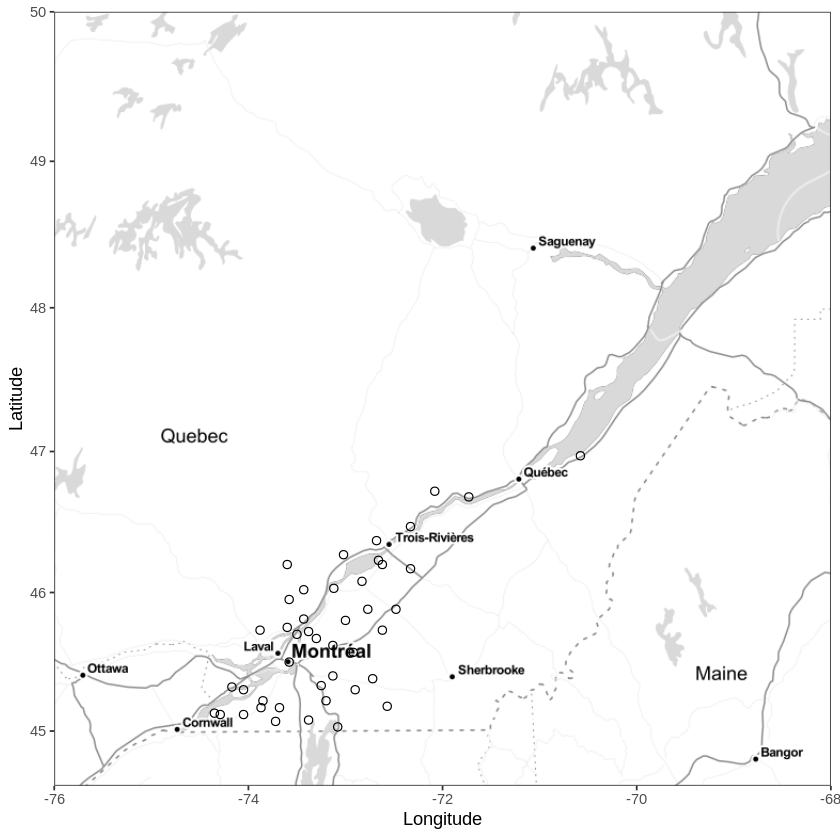

In [4]:
ggmap(qc_map) +
  geom_point(data = main_data %>% 
  select(Lon, Lat) %>%
  unique(),
             mapping = aes(x = Lon, y = Lat),
             size = 2, shape = 1) + 
  coord_map("mercator") +
  labs(x = "Longitude", y = "Latitude") +
  theme_bw()
ggsave("images/map.jpg", width=10, height=8, dpi = 300)

### Weather

The definition of weather indices are as follows.

| Column name | Description | Abbreviation | Unit | Formula |
| ----------- | ----------- | ------------ | ---- | ------- |
| `pcpCum` | Cumulated precipitations | CP | mm | $\Sigma_{i=1}^n R_{di}$ where $R_{di}$ is the height of precipitations measured at the $i^{th}$ day |
| `CHU` | Corn heat unit | CHU | °C | $CHU = \frac{Y_{max} + Y_{min}}{2}$<br>$Y_{max} = \begin{cases} 3.33 \left( T_{max} - 10  \right) - 0.084 \left( T_{max} - 10 \right)^2 ~~if~~T_{max} \geq 10°C \\ 0~~if~~T_{max} < 10°C \end{cases}$<br> $Y_{min} = \begin{cases} 1.8 \left( T_{min} - 4.44 \right)~~if~~T_{min} \geq 4.44°C \\ 0~~if~~T_{min} < 4.44°C \end{cases}$ |
| `Tmean` | Mean temperature | MT | °C | $\Sigma_{i=1}^n \frac{T_i}{n}$ where $T_i$ is the temperature measured at the $i^{th}$ day |
| `SDI` | Shannon diversity index of precipitations | SDI | - |   $\frac{-\Sigma_{i=1}^n p_i \times ln \left( p_i \right)}{ln \left( n \right)}$  where $p_i = \frac{R_{di}}{\Sigma_{i=1}^n R_{di}}$ is the fraction of daily rainfall relative to the total rainfall during a given time period and $n$ is the number of days for that period. |
| `DJCb` | Degree days of growth in base 5°C | DD | °C | $\frac{T_{max} - T_{min}}{2} - 5$ where $T_{max}$ and $T_{min}$ are maximum and minimum temperatures |
| `AWDR` | Abundant well-distributed rainfall | AWDR | mm | $\Sigma_{i=1}^n R_{di} \times SDI$ | 
| `Nb3po3j` | Leaching events | NLE | - | Number of events of ≥ 3 inches during 3 consecutive days |
| `etpBRcum` | Daily Baier-Robertson evapotranspiration | ETP | mm | $-5.39+0.157 \times T_{max} + 0.158 \times \left(T_{max}-T_{min} \right) + 0.00457 \times RA$ where $RA$ is extraterrestrial radiation ($calory \cdot gram \cdot cm^{-1} \cdot d^{-1} = Langley$). |
| `IhBR` | Thorntwaite humidity index | THI | % | $100 \times \frac{\Sigma_{i=1}^n R_{di} - ETP}{ETP}$ |

### Soil series

The soil morphology is consigned in its own table. Soil series can be merged to the main data by the column named `ProprieteSol.SerieSol`.

In [5]:
soil_series <- read_csv("data/soil_series.csv")

Parsed with column specification:
cols(
  `Soil Series` = col_character(),
  `Associated Series` = col_character(),
  Cansis = col_character(),
  m.3a = col_double(),
  m.3b = col_double(),
  m.3c = col_double()
)


### Correct P sources

In [6]:
main_data$P.Source[main_data$P.Source == "SPT" & !is.na(main_data$P.Source)] <- "TSP"
main_data$P.Source[main_data$P.Source == "PBA" & !is.na(main_data$P.Source)] <- "DAP"
main_data$P.Source[main_data$P.Source == "DAP OM" & !is.na(main_data$P.Source)] <- "OMF"
main_data$P.Source[main_data$P.Source == "MAP OM" & !is.na(main_data$P.Source)] <- "OMF"
main_data$P.Source[is.na(main_data$P.Source)] <- "DAP"
main_data$P.Source <- relevel(factor(main_data$P.Source), ref = "DAP")

### Variable translation to English

Table headers are recorded in French, and because plots need pretty names, we created a handy table to translate terms.

In [7]:
translate_col <- read_csv(file = "data/translate_colnames.csv")

Parsed with column specification:
cols(
  from_name_mm = col_character(),
  to_name_mm = col_character(),
  to_name_mm_long_en = col_character(),
  to_name_mm_long_fr = col_character()
)
Warning message:
“2 parsing failures.
row                col                     expected actual                          file
 30 to_name_mm_long_fr delimiter or quote                  'data/translate_colnames.csv'
 30 to_name_mm_long_fr closing quote at end of file        'data/translate_colnames.csv'
”

### Data merging

Weld all tables in a unique data frame.

In [8]:
data <- main_data %>%
  left_join(soil_series, by = "Soil Series")

![](https://media.giphy.com/media/1wQbGbrJMytXOOXnkp/giphy.gif)

## Arrange data

The column `data$Manure` specifies which kind of manure is applied, if any. If no manure is applied, the row is tagged with `Aucun` (none). We remove the lactoserum from the data set. A boolean column is added to specify if manure was indeed applied.

In [9]:
data <- data %>%
  filter(Manure != "lactosérum")

In [10]:
data$is_manure <- ifelse(data$Manure == "none", FALSE, TRUE)

## Statistics

In [11]:
data %>%
  pull(`Plant density`) %>%
  summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  50861   72062   75238   75496   79571   96544      41 

## Weather indices

We have numerous weather indices. Many of these indices are redundant. In this section, we will select the most relevant indices. Pairs plot can give a first glance, but we need functions to create appropriate pairs plots.

In [12]:
panel.hist <- function(x, ...) {
  usr = par("usr"); on.exit(par(usr))
  par(usr = c(usr[1:2], 0, 1.5) )
  h = hist(x, plot = FALSE)
  breaks = h$breaks; nB = length(breaks)
  y = h$counts; y = y/max(y)
  rect(breaks[-nB], 0, breaks[-1], y, col = "cyan", ...)
}
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...) {
  usr = par("usr"); on.exit(par(usr))
  par(usr = c(0, 1, 0, 1))
  r = abs(cor(x, y))
  txt = format(c(r, 0.123456789), digits = digits)[1]
  txt = paste0(prefix, txt)
  if(missing(cex.cor)) cex.cor = 0.8/strwidth(txt)
  text(0.5, 0.5, txt, cex = cex.cor * r)
}

The following plot presents indices related to **precipitations** through the whole season.

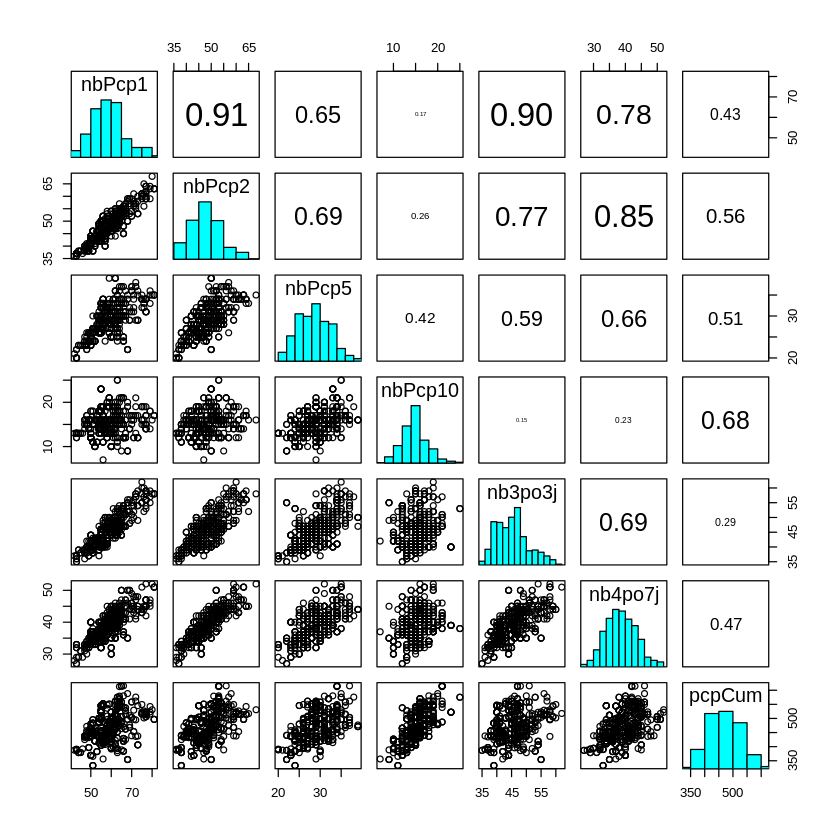

In [13]:
options(repr.plot.width = 7, repr.plot.height = 7)
data %>%
  select(c("nbPcp1", "nbPcp2", "nbPcp5", "nbPcp10", "nb3po3j", "nb4po7j", "pcpCum")) %>%
  drop_na() %>%
  pairs(upper.panel = panel.cor, diag.panel = panel.hist)

And the precipitations for the first 30 days of the season.

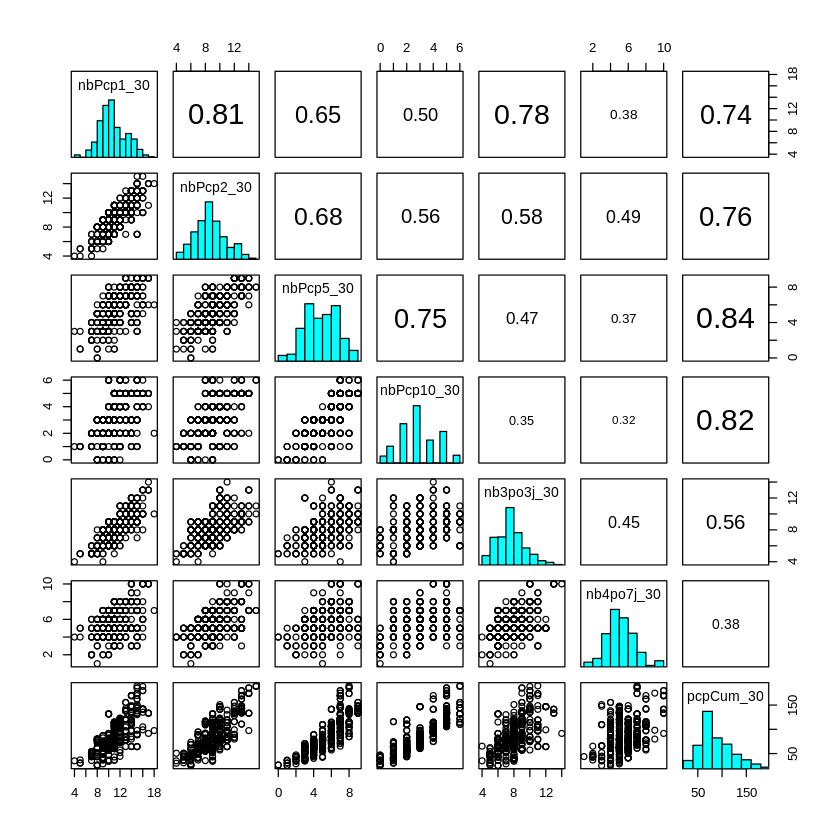

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)
data %>%
  select(c("nbPcp1_30", "nbPcp2_30", "nbPcp5_30", "nbPcp10_30", "nb3po3j_30", "nb4po7j_30", "pcpCum_30")) %>%
  drop_na() %>%
  pairs(upper.panel = panel.cor, diag.panel = panel.hist)

We will retain the cumulated precipitations (`pcpcum`) as well as the leaching index (number of events with more than 3 inches of precipitations in 3 days, `nb3po3j`). To obtain are more concise look at the whole picture, we use a principal component analysis.

In [15]:
weather_pca_cols <- c('pcpCum', 'SDI', 'AWDR', 'IhBR', 'etpBRcum', 'tMean', 'DDCb', 'nb3po3j', 'CTU')
weather_pca <- data %>%
  select(weather_pca_cols) %>%
  drop_na() %>%
  rda(., scale = TRUE)

To evaluate the representativity of the two first axes, we compute the percentage of inertia.

In [16]:
inertia <- t(data.frame(inertia = 100 * weather_pca$CA$eig / length(weather_pca$CA$eig)))
inertia[1] + inertia[2]

[1] 79.37808

The two first axes include nearly 83% of the variance, which is largely sufficient. In a correlation biplot (`scaling=2`), the angles between vectors are proportionnal to their correlation.

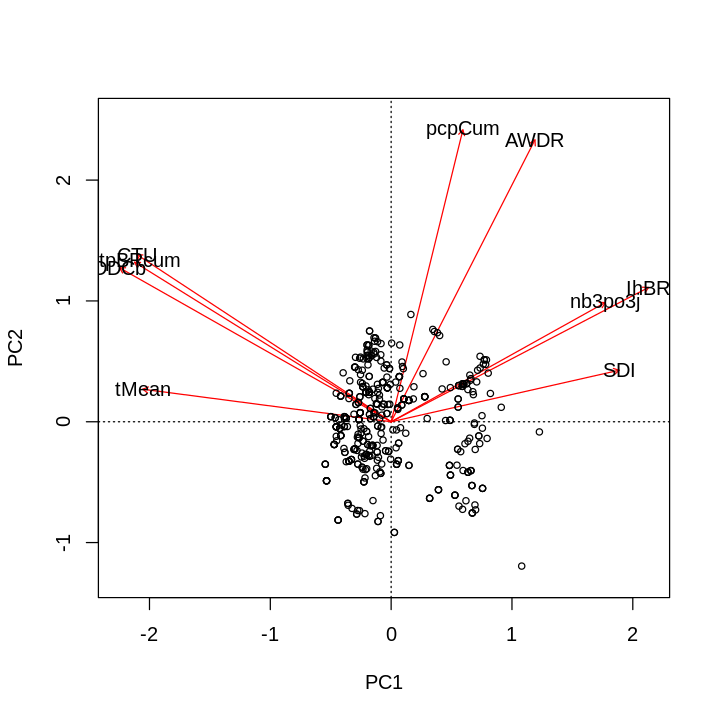

In [17]:
options(repr.plot.width = 6, repr.plot.height = 6)
biplot(weather_pca, scaling=2)
text(weather_pca, scaling=2, display = 'species')

The first principal component in mostly aligned with SDI and tMean. On the bottom-right, a group of (DJCb, UTMc, eptBRcum) are closely correlated. On bottom right, (pcpCum, and ADWR) are closely correlated, as are nb3po3j and IhBR. We selected SDI, UTMc and pcpCum.

In [18]:
weather_vars <- c("SDI", "CTU", "pcpCum")

The same exercice can be done for the weather through the first 30 days of the growing season.

In [19]:
weather_pca_cols_.30 <- c('pcpCum_30', 'SDI_30', 'AWDR_30', 'IhBR_30', 'etpBRcum_30', 'tMean_30', 'DDCb_30', 'nb3po3j_30', 'CTU_30')
weather_pca_.30 <- data %>%
  select(weather_pca_cols_.30) %>%
  drop_na() %>%
  rda(., scale = TRUE)
inertia_.30 <- t(data.frame(inertia = 100 * weather_pca_.30$CA$eig / length(weather_pca_.30$CA$eig)))
inertia_.30[1] + inertia_.30[2]

[1] 85.2636

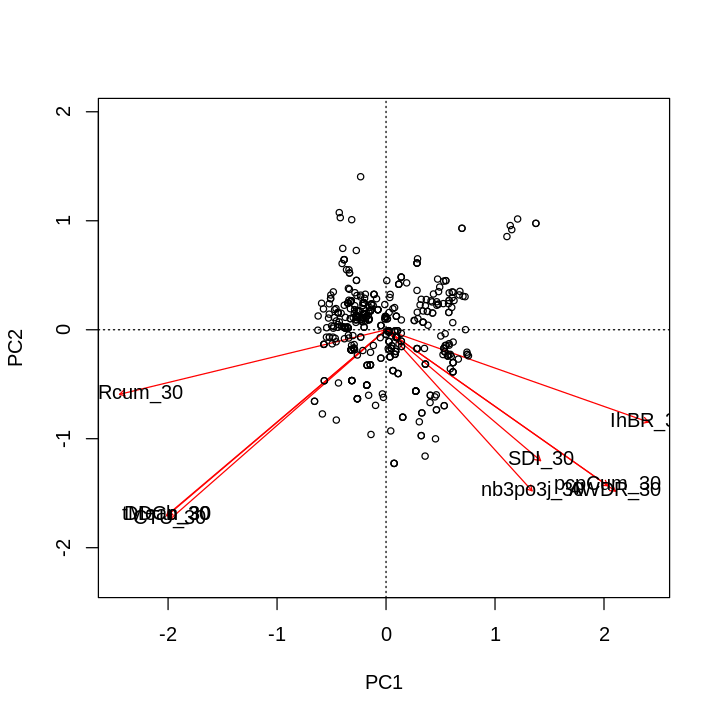

In [20]:
options(repr.plot.width = 6, repr.plot.height = 6)
biplot(weather_pca_.30, scaling=2)
text(weather_pca_.30, display = 'species', scaling=2)

There are two groups of indices. We selected `pcpCum_30` for the bottom right group and `CTU_30` for the bottom left group.

In [21]:
weather_vars_.30 <- c('pcpCum_30', 'CTU_30')

## Soil analysis

### Soil P and Al

The Phosphorus-Aluminium ratio in soils has been identified to be an important index to assess the amount of phosphorus fertilizer to add.

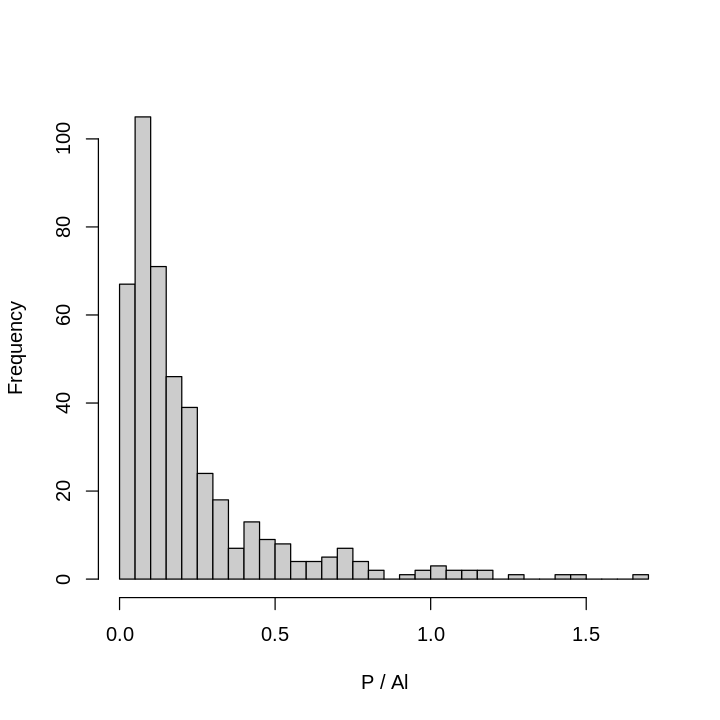

In [22]:
data <- data %>%
  mutate(Soil_P.Al = Soil.MIII.P.ICP_mg.kg / Soil.MIII.Al.ICP_mg.kg)
hist(data$Soil_P.Al, xlab = 'P / Al', breaks = 30, col = 'grey80', main='')

The pattern show a log-normal distribution, which could be corrected by the use of a log-ratio. However, we will keep P/Al further on since this is a common metric used in agriculture.

### Soil morphology

Soil morphology is described with three proportions describing tendency to belong to loam gley, sandy gley and podzol. These proportions are transformed to [gley | podzol] and [loam gley | sandy gley] balances using ilrs. We create the SBP and compute the ilrs just as we did previously.

In [23]:
soilTypeSBP <- matrix(c(-1, 1,-1,
                        -1, 0, 1),
                      byrow = TRUE,
                      ncol = 3)

colnames(soilTypeSBP) <- c('loam.gley', 'sand.podzol', 'sand.gley')
soilTypeComp <- acomp(data[c('m.3a', 'm.3b', 'm.3c')])

soilTypeBal <- ilr(soilTypeComp, V = gsi.buildilrBase(t(soilTypeSBP)))
soilTypeBal <- ilrNA(comp = soilTypeComp, sbp = soilTypeSBP, bal = soilTypeBal)

data$SoilSeries_G.P <- soilTypeBal[, 1] # ilr1 [gley | podzol]
data$SoilSeries_LG.SG <- soilTypeBal[, 2] # ilr2 gley.[fine | coarse]

### Soil texture

Some textures in the data set are only expressed as textural classes. To transform them to sand, silt and clay proportions, we created a table including the centroid of proportions for each textural class. We import this table, then filter out the textural classes which are absent from our main data table.

In [24]:
qcTextCentroid = read_csv('data/centroids_texture.csv')

qcTextCentroid <- qcTextCentroid %>%
  filter(Texture %in% unique(data$Texture)) %>%
  droplevels() # filter to take only the levels present in data$ProprieteSol.ClasseTexturale

Parsed with column specification:
cols(
  Texture.code = col_character(),
  Texture = col_character(),
  ClayCentroid = col_double(),
  SiltCentroid = col_double(),
  SandCentroid = col_double()
)


Then we join the proportions to the main data table according to the textural class.

In [25]:
data <- left_join(data, qcTextCentroid, by = "Texture")

Absent proportions are imputed with the centroid of the described textural class.

In [26]:
data$`Clay %`[is.na(data$`Clay %`)] <- data$ClayCentroid[is.na(data$`Clay %`)]
data$`Sand %`[is.na(data$`Sand %`)] <- data$SandCentroid[is.na(data$`Sand %`)]
data$`Silt %` <- 100 - data$`Clay %` - data$`Sand %`

The textural proportions, as well as the organic matter, form a soil simplex that can be transformed to ilrs. Because there are some missing values in the organic matter column (`SOM_%`), we will perform some imputations before computing soil textural and organic content balances.

### pH and organic matter

pH is partly related to organic matter. Because there are a lot of missing values in both of these columns, we use imputations. The following plot illustrates the status of missing values for pH and organic matter.

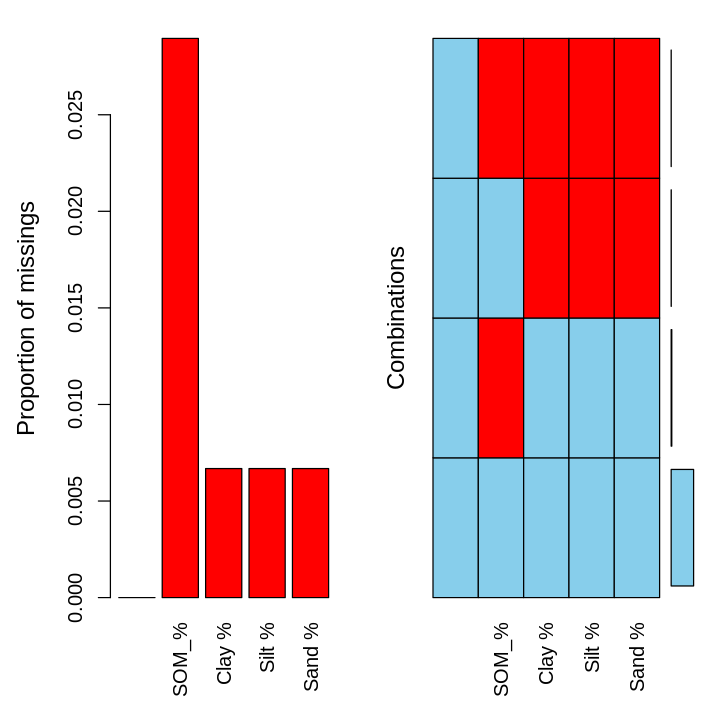

In [27]:
data %>%
  select(`Soil pH_H2O`, 
         `SOM_%`,
         `Clay %`,
         `Silt %`,
         `Sand %`) %>%
  aggr(.)

Imputed textures will not be used. The random forest algorithm is used to fill the wholes.

In [28]:
pH.SOM_mice <- data %>%
  select(`Soil pH_H2O`, 
         `SOM_%`,
         `Clay %`,
         `Silt %`,
         `Sand %`) %>%
  # rename because mice dislikes non-standard column names
  rename(pH = "Soil pH_H2O",
         SOM = "SOM_%",
         clay = "Clay %",
         silt = "Silt %",
         sand = "Sand %"
        ) %>%
  mice(., m = 1, method = 'rf', seed = 6561874, print = FALSE)
pH.SOM_imp <- complete(pH.SOM_mice)
pH.SOM_imp[is.na(data['Soil pH_H2O']) & is.na(data['SOM_%']), ] <- NA

The imputed columns are included in the main data table.

In [29]:
data['pH'] = pH.SOM_imp[, 1]
data['SOM_%_imp'] = pH.SOM_imp[, 2]

### Soil texture balances

Back to soil textures and organic matter. We create a table including soil parts, then a compositional matrix with the `acomp` data class.

In [30]:
soilTextParts <- cbind(data$`SOM_%_imp`*0.58,
                      (100 - data$`SOM_%_imp`*0.57) * data[c('Clay %',
                                                        'Silt %',
                                                        'Sand %')] / 100)
soilTextComp <- acomp(soilTextParts)

Just as we did previously with ilr transformations, we create [Carbon| clay,silt,Sand], [clay | silt,Sand] and [silt | Sand] soil balances and put them in the main data table.

In [31]:
soilTextSBP <- matrix(c(-1, 1, 1, 1,
                         0, 1, 1,-1,
                         0, 1,-1, 0),
                      byrow = TRUE,
                      ncol = 4)
colnames(soilTextSBP) <- c('Carbon', 'Sand', 'silt', 'clay') # C: Carbone (carbon), S: Sable (sand), s: Limon (silt), c: Argile (clay)
soilTextBal <- ilr(soilTextComp, V = gsi.buildilrBase(t(soilTextSBP)))
colnames(soilTextBal) <- c("[Carbon| clay,silt,Sand]", "[clay | silt,Sand]", "[silt | Sand]")
soilTextBal <- ilrNA(soilTextComp, soilTextSBP, soilTextBal)

data$Texture_C.asS <- soilTextBal[, 1]
data$Texture_a.sS <- soilTextBal[, 2]
data$Texture_s.S <- soilTextBal[, 3]

### Soil variables

Before we create a table ready to be analyzed, we create a vector of explicative variables to be included.

In [32]:
soil_vars <- c("pH", "is_manure", 'Soil_P.Al',
               'SoilSeries_G.P', 'SoilSeries_LG.SG', # soil morphology
               "Texture_C.asS", "Texture_a.sS", "Texture_s.S") # soil texture

Note: the use of weather variables depend on the model used. They will be added to predictors when data will be assembled specifically for models.

## Reshape data for P dosage

In the `data` table, each dose level has its own column. They will be tidied into a single column later in the script. The vector `dose_vars` includes the names of these columns.

In [33]:
dose_vars <- c("P.rate_kgP2o5.ha_ctrl", "P.rate_kgP2o5.ha_1",
               "P.rate_kgP2o5.ha_2", "P.rate_kgP2o5.ha_3",
               "P.rate_kgP2o5.ha_4")

This section aims at unify them in a single column. We first create the new table `data_rs`, including the columns we are interested in in `data`. We then *gather* `dose_vars` columns to treatment label `traitementP` (which column the dose comes from) and a Phosphorus dose `doseP` columns. We also reorder the table by ID and treatment. The dose expressed as P2O5, not P. Let's convert to P doses.

In [34]:
data_rs <- data %>%
  select(c("ID",
           "Year",
           "Plant density",
           "P.Source",
           "Soil.MIII.P.ICP_mg.kg",
           soil_vars,
           weather_vars,
           weather_vars_.30,
           dose_vars)) %>%
  rename(control = P.rate_kgP2o5.ha_ctrl,
         dose1 = P.rate_kgP2o5.ha_1,
         dose2 = P.rate_kgP2o5.ha_2,
         dose3 = P.rate_kgP2o5.ha_3,
         dose4 = P.rate_kgP2o5.ha_4) %>%
  gather(key = "P_treatment", value = "doseP", control, dose1, dose2, dose3, dose4) %>%
  mutate(doseP = doseP * 0.4364) %>%
  arrange(ID)
head(data_rs)

ID,Year,Plant density,P.Source,Soil.MIII.P.ICP_mg.kg,pH,is_manure,Soil_P.Al,SoilSeries_G.P,SoilSeries_LG.SG,Texture_C.asS,Texture_a.sS,Texture_s.S,SDI,CTU,pcpCum,pcpCum_30,CTU_30,P_treatment,doseP
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
110,2001,75000,MAP,95.8,5.9,FALSE,0.1211431,-3.618415,-4.073011,2.569953,-0.2698994,-0.417095,0.7278946,3344.156,413.39,66.48,504.5047,control,0.000
110,2001,75000,MAP,95.8,5.9,FALSE,0.1211431,-3.618415,-4.073011,2.569953,-0.2698994,-0.417095,0.7278946,3344.156,413.39,66.48,504.5047,dose1,8.728
110,2001,75000,MAP,95.8,5.9,FALSE,0.1211431,-3.618415,-4.073011,2.569953,-0.2698994,-0.417095,0.7278946,3344.156,413.39,66.48,504.5047,dose2,NA
110,2001,75000,MAP,95.8,5.9,FALSE,0.1211431,-3.618415,-4.073011,2.569953,-0.2698994,-0.417095,0.7278946,3344.156,413.39,66.48,504.5047,dose3,NA
110,2001,75000,MAP,95.8,5.9,FALSE,0.1211431,-3.618415,-4.073011,2.569953,-0.2698994,-0.417095,0.7278946,3344.156,413.39,66.48,504.5047,dose4,NA
111,2001,75000,OMF,95.8,5.9,FALSE,0.1211431,-3.618415,-4.073011,2.569953,-0.2698994,-0.417095,0.7278946,3344.156,413.39,66.48,504.5047,control,0.000


Performance indices are also declined by dose rate. This should also be tidied. I will proceed by tidying each performance variable individually in the aim at merging them to `data_rs` afterwards.

In [35]:
rdt <- data %>%
  select(ID, starts_with("Yield_t.ha_")) %>%
  rename(control = Yield_t.ha_ctrl,
         dose1 = Yield_t.ha_1,
         dose2 = Yield_t.ha_2,
         dose3 = Yield_t.ha_3,
         dose4 = Yield_t.ha_4) %>%
  gather(key = "P_treatment", value = "yield_t.ha", -ID) %>%
  arrange(ID)
head(rdt)

ID,P_treatment,yield_t.ha
<dbl>,<chr>,<dbl>
110,control,6.0
110,dose1,6.4
110,dose2,NA
110,dose3,NA
110,dose4,NA
111,control,6.0


In [36]:
dens <- data %>%
  select(ID, starts_with("Grain density g.L")) %>%
  rename(control = `Grain density g.L ctrl`,
         dose1 = `Grain density g.L 1`,
         dose2 = `Grain density g.L 2`,
         dose3 = `Grain density g.L 3`,
         dose4 = `Grain density g.L 4`) %>%
  gather(key = "P_treatment", value = "graindensity_g.L", -ID) %>%
  arrange(ID)
head(dens)

ID,P_treatment,graindensity_g.L
<dbl>,<chr>,<dbl>
110,control,686.0
110,dose1,687.3
110,dose2,NA
110,dose3,NA
110,dose4,NA
111,control,686.0


In [37]:
hum <- data %>%
  select(ID, starts_with("Grain mositure %")) %>%
  rename(control = `Grain mositure % ctrl`,
         dose1 = `Grain mositure % 1`,
         dose2 = `Grain mositure % 2`,
         dose3 = `Grain mositure % 3`,
         dose4 = `Grain mositure % 4`) %>%
  gather(key = "P_treatment", value = "grainmoisture_perc", -ID) %>%
  arrange(ID)
head(hum)

ID,P_treatment,grainmoisture_perc
<dbl>,<chr>,<dbl>
110,control,9.5
110,dose1,10.1
110,dose2,NA
110,dose3,NA
110,dose4,NA
111,control,9.5


In [38]:
height <- data %>%
  select(ID, starts_with("MaxLeafLength_cm_")) %>%
  rename(control = `MaxLeafLength_cm_ctrl`,
         dose1 = `MaxLeafLength_cm_1`,
         dose2 = `MaxLeafLength_cm_2`,
         dose3 = `MaxLeafLength_cm_3`) %>%
  gather(key = "P_treatment", value = "plantheight_cm", -ID) %>%
  mutate(plantheight_mm = plantheight_cm * 10) %>% # in mm instead of cm
  select(-plantheight_cm) %>%
  arrange(ID)
head(height)

ID,P_treatment,plantheight_mm
<dbl>,<chr>,<dbl>
110,control,582
110,dose1,621
110,dose2,NA
110,dose3,NA
111,control,582
111,dose1,602


In [39]:
data_rs <- data_rs %>%
  left_join(rdt, by = c("ID", "P_treatment")) %>%
  left_join(dens, by = c("ID", "P_treatment")) %>%
  left_join(hum, by = c("ID", "P_treatment")) %>%
  left_join(height, by = c("ID", "P_treatment")) %>%
  mutate(ID = factor(ID))

In [40]:
data_rs %>%
  sample_n(10)

ID,Year,Plant density,P.Source,Soil.MIII.P.ICP_mg.kg,pH,is_manure,Soil_P.Al,SoilSeries_G.P,SoilSeries_LG.SG,⋯,CTU,pcpCum,pcpCum_30,CTU_30,P_treatment,doseP,yield_t.ha,graindensity_g.L,grainmoisture_perc,plantheight_mm
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
349,1999,73510,DAP,357.0,7.00,TRUE,0.44736842,-2.016598,1.623109,⋯,3178.478,614.55,92.49,512.8255,dose3,NA,NA,NA,NA,NA
513,2001,79606,AAP,165.0,6.50,TRUE,0.15137615,NA,NA,⋯,3398.932,431.28,43.20,494.8272,dose1,6.9824,8.300,NA,20.7,NA
411,2001,NA,DAP,200.8,7.10,TRUE,0.27565643,NA,NA,⋯,3460.828,483.37,44.44,477.1924,control,0.0000,10.000,NA,27.1,NA
478,2000,65625,DAP,47.0,6.40,FALSE,0.04408840,-1.676409,-1.675602,⋯,2798.240,481.88,114.76,436.1142,control,0.0000,8.000,NA,28.4,NA
306,2001,83000,DAP,82.4,5.50,FALSE,0.08477366,-1.292980,1.701000,⋯,3238.496,418.60,83.13,506.1809,control,0.0000,9.894,771,31.3,NA
460,1999,72479,DAP,94.0,6.60,FALSE,0.09957627,NA,NA,⋯,3349.624,579.02,65.21,511.6869,dose4,NA,NA,NA,NA,NA
209,1999,72000,OMF,72.1,6.10,FALSE,0.05373379,-1.107344,-1.194644,⋯,3275.512,484.47,81.55,559.9739,dose1,9.6008,8.351,735,34.9,442
550,2001,80000,TSP,144.8,6.32,FALSE,0.18977720,-1.879138,-1.949716,⋯,3504.472,467.55,61.54,510.4623,dose3,NA,NA,NA,NA,NA
545,2002,NA,DAP,226.3,6.20,TRUE,0.22995631,NA,NA,⋯,3305.276,504.68,114.57,202.6789,dose1,NA,NA,NA,NA,NA


We create a vector of performance variables.

In [41]:
performance_vars <- c("yield_t.ha", "graindensity_g.L", "grainmoisture_perc", "plantheight_mm")

## Convert plant height to plant biomass

We use the equation.

$$biomass = e^{2.433 \times ln(lenght) - 8.718}$$

Biomass is in grams and lenght in cm.

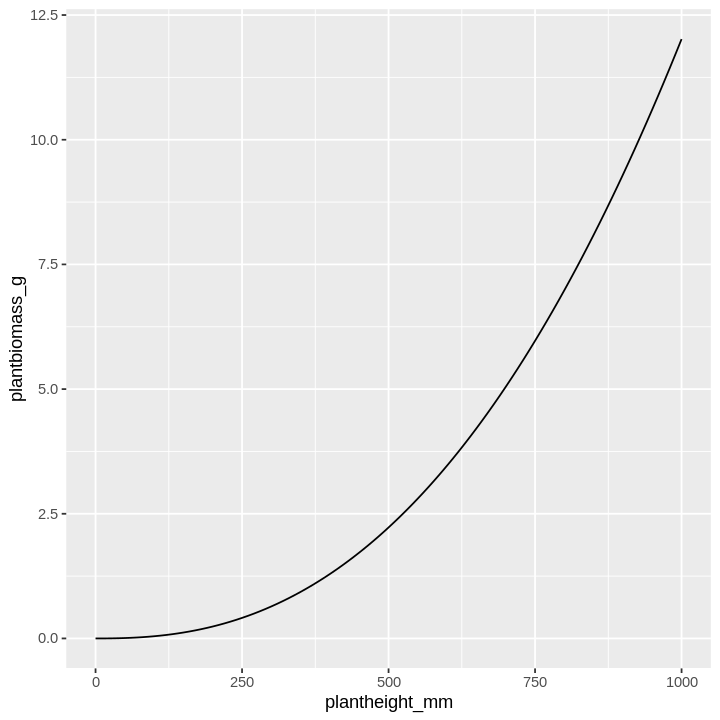

In [42]:
tibble(plantheight_mm = seq(0, 1000, 10)) %>%
  mutate(plantbiomass_g = exp(2.433 * log(plantheight_mm/10) - 8.718)) %>%
  ggplot(aes(x = plantheight_mm, y = plantbiomass_g)) +
  geom_line()

In [43]:
data_rs <- data_rs %>%
  mutate(plantbiomass_g = exp(2.433 * log(plantheight_mm/10) - 8.718))

## Export preprocessed session

The project is split to different notebooks. This first notebook aims only as preprocessing. Relevant objects must be exported for further use in notebooks focussing on modelling.

In [44]:
save(data_rs, soil_vars, weather_vars, weather_vars_.30, performance_vars, translate_col,
    file="output/preprocessed.RData")